**Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

np.random.seed(42)

**Synthetic Dataset**

X shape: (2000, 2) y shape: (2000,) unique classes: [0 1 2 3 4]


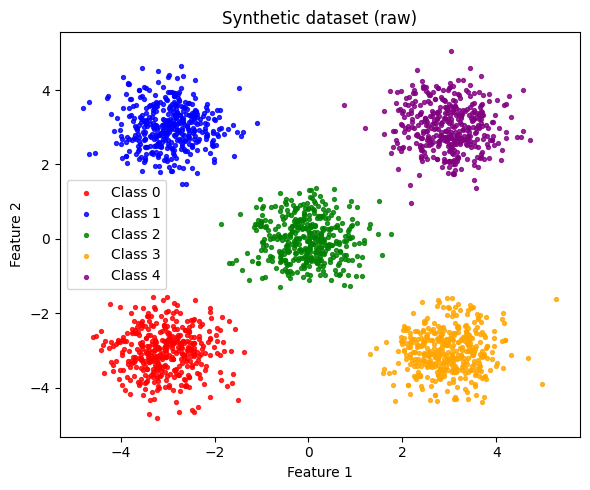

In [4]:
def generate_synthetic_data(samples_per_class=200, centers=None, std=0.6, random_state=None):

    if random_state is not None:
        np.random.seed(random_state)

    if centers is None:
        centers = [(-3, -3), (-3, 3), (0, 0), (3, -3), (3, 3)]

    X_list = []
    y_list = []
    for class_id, (cx, cy) in enumerate(centers):
        pts = np.random.randn(samples_per_class, 2) * std + np.array([cx, cy])
        X_list.append(pts)
        y_list.append(np.full(samples_per_class, class_id, dtype=int))

    X = np.vstack(X_list)
    y = np.hstack(y_list)

    perm = np.random.permutation(len(X))
    return X[perm], y[perm]

X, y = generate_synthetic_data(samples_per_class=400, random_state=0)  # 400 * 5 = 2000 samples
print("X shape:", X.shape, "y shape:", y.shape, "unique classes:", np.unique(y))

colors = ['red', 'blue', 'green', 'orange', 'purple']
plt.figure(figsize=(6,5))
for i in range(5):
    mask = (y == i)
    plt.scatter(X[mask,0], X[mask,1], s=8, color=colors[i], label=f"Class {i}", alpha=0.8)
plt.title("Synthetic dataset (raw)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.tight_layout()
plt.show()

**Train - Test**

In [6]:
num_classes = 5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

mean = X_train.mean(axis=0, keepdims=True)
std  = X_train.std(axis=0, keepdims=True) + 1e-8
X_train_norm = (X_train - mean) / std
X_test_norm  = (X_test  - mean) / std

def one_hot_encode(y, num_classes):
    O = np.zeros((y.shape[0], num_classes), dtype=float)
    O[np.arange(y.shape[0]), y] = 1.0
    return O

Y_train_oh = one_hot_encode(y_train, num_classes)
Y_test_oh  = one_hot_encode(y_test, num_classes)

print("Train:", X_train_norm.shape, Y_train_oh.shape, "Test:", X_test_norm.shape, Y_test_oh.shape)


Train: (1600, 2) (1600, 5) Test: (400, 2) (400, 5)


**Neural network**

In [11]:
class ThreeHiddenLayerNN:
    def __init__(self, input_dim, h1, h2, h3, output_dim, learning_rate=0.05, seed=42):
        np.random.seed(seed)
        self.lr = learning_rate

        self.W1 = np.random.randn(input_dim, h1) / np.sqrt(input_dim)
        self.b1 = np.zeros((1, h1))

        self.W2 = np.random.randn(h1, h2) / np.sqrt(h1)
        self.b2 = np.zeros((1, h2))

        self.W3 = np.random.randn(h2, h3) / np.sqrt(h2)
        self.b3 = np.zeros((1, h3))

        self.W4 = np.random.randn(h3, output_dim) / np.sqrt(h3)
        self.b4 = np.zeros((1, output_dim))


    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def softmax(self, x):
        x_shift = x - np.max(x, axis=1, keepdims=True)
        ex = np.exp(x_shift)
        return ex / np.sum(ex, axis=1, keepdims=True)


    def forward(self, X):
        self.X = X
        self.z1 = X.dot(self.W1) + self.b1
        self.a1 = self.relu(self.z1)

        self.z2 = self.a1.dot(self.W2) + self.b2
        self.a2 = self.relu(self.z2)

        self.z3 = self.a2.dot(self.W3) + self.b3
        self.a3 = self.relu(self.z3)

        self.z4 = self.a3.dot(self.W4) + self.b4
        self.a4 = self.softmax(self.z4)
        return self.a4

    def cross_entropy(self, Y_true, Y_pred):
        eps = 1e-12
        Y_pred_clipped = np.clip(Y_pred, eps, 1 - eps)
        return -np.mean(np.sum(Y_true * np.log(Y_pred_clipped), axis=1))


    def backward(self, Y_true, Y_pred):
        N = Y_true.shape[0]

        # output layer
        dZ4 = (Y_pred - Y_true) / N
        dW4 = self.a3.T.dot(dZ4)
        db4 = np.sum(dZ4, axis=0, keepdims=True)

        dA3 = dZ4.dot(self.W4.T)
        dZ3 = dA3 * self.relu_derivative(self.z3)
        dW3 = self.a2.T.dot(dZ3)
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        dA2 = dZ3.dot(self.W3.T)
        dZ2 = dA2 * self.relu_derivative(self.z2)
        dW2 = self.a1.T.dot(dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        dA1 = dZ2.dot(self.W2.T)
        dZ1 = dA1 * self.relu_derivative(self.z1)
        dW1 = self.X.T.dot(dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)


        self.W4 -= self.lr * dW4
        self.b4 -= self.lr * db4

        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3

        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def predict_proba(self, X):
        return self.forward(X)

    def predict_class(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)


**Model & Train**

In [12]:
input_dim = X_train_norm.shape[1]
h1, h2, h3 = 64, 32, 16
output_dim = num_classes
lr = 0.08

model = ThreeHiddenLayerNN(input_dim, h1, h2, h3, output_dim, learning_rate=lr, seed=123)

epochs = 1200
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for ep in range(epochs):

    preds_train = model.forward(X_train_norm)
    loss_train = model.cross_entropy(Y_train_oh, preds_train)

    model.backward(Y_train_oh, preds_train)


    preds_test = model.predict_proba(X_test_norm)
    loss_test = model.cross_entropy(Y_test_oh, preds_test)


    y_pred_train = np.argmax(preds_train, axis=1)
    y_pred_test  = np.argmax(preds_test, axis=1)
    acc_train = np.mean(y_pred_train == y_train)
    acc_test  = np.mean(y_pred_test  == y_test)

    train_losses.append(loss_train)
    test_losses.append(loss_test)
    train_accs.append(acc_train)
    test_accs.append(acc_test)

    if ep % 150 == 0 or ep == epochs-1:
        print(f"Epoch {ep:4d} | Train Loss: {loss_train:.4f} | Test Loss: {loss_test:.4f} | Train Acc: {acc_train:.4f} | Test Acc: {acc_test:.4f}")

print("Training complete.")

Epoch    0 | Train Loss: 1.6244 | Test Loss: 1.5334 | Train Acc: 0.3719 | Test Acc: 0.4050
Epoch  150 | Train Loss: 0.0818 | Test Loss: 0.0827 | Train Acc: 0.9988 | Test Acc: 1.0000
Epoch  300 | Train Loss: 0.0200 | Test Loss: 0.0218 | Train Acc: 1.0000 | Test Acc: 1.0000
Epoch  450 | Train Loss: 0.0092 | Test Loss: 0.0105 | Train Acc: 1.0000 | Test Acc: 1.0000
Epoch  600 | Train Loss: 0.0056 | Test Loss: 0.0066 | Train Acc: 1.0000 | Test Acc: 1.0000
Epoch  750 | Train Loss: 0.0039 | Test Loss: 0.0047 | Train Acc: 1.0000 | Test Acc: 1.0000
Epoch  900 | Train Loss: 0.0030 | Test Loss: 0.0036 | Train Acc: 1.0000 | Test Acc: 1.0000
Epoch 1050 | Train Loss: 0.0024 | Test Loss: 0.0029 | Train Acc: 1.0000 | Test Acc: 1.0000
Epoch 1199 | Train Loss: 0.0020 | Test Loss: 0.0024 | Train Acc: 1.0000 | Test Acc: 1.0000
Training complete.


**Plot loss & accuracy curves**

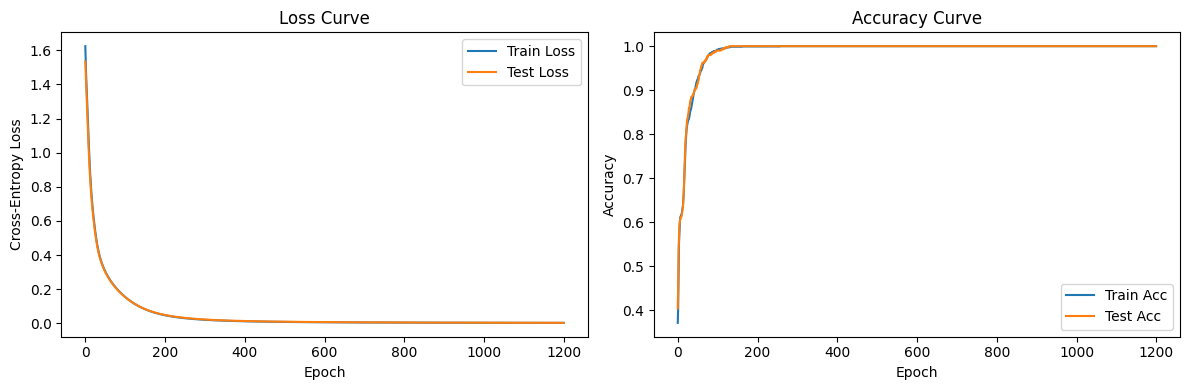

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.tight_layout()
plt.show()


**Evaluation**


Confusion Matrix (rows=true, cols=pred):
 [[80  0  0  0  0]
 [ 0 80  0  0  0]
 [ 0  0 80  0  0]
 [ 0  0  0 80  0]
 [ 0  0  0  0 80]]

Overall Test Accuracy: 1.0000

Class 0: Precision=1.000, Recall=1.000, F1=1.000, Support=80
Class 1: Precision=1.000, Recall=1.000, F1=1.000, Support=80
Class 2: Precision=1.000, Recall=1.000, F1=1.000, Support=80
Class 3: Precision=1.000, Recall=1.000, F1=1.000, Support=80
Class 4: Precision=1.000, Recall=1.000, F1=1.000, Support=80

Macro Precision: 1.000, Macro Recall: 1.000, Macro F1: 1.000


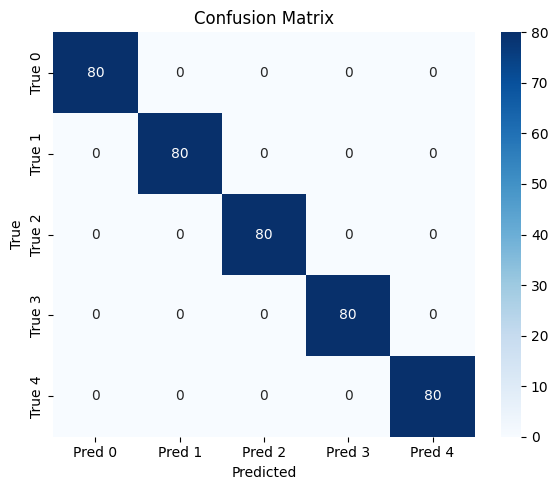

In [14]:
probs_test = model.predict_proba(X_test_norm)
y_test_pred = np.argmax(probs_test, axis=1)

cm = confusion_matrix(y_test, y_test_pred)
acc = accuracy_score(y_test, y_test_pred)
prec, rec, f1, sup = precision_recall_fscore_support(y_test, y_test_pred, average=None, labels=np.arange(num_classes))

print("\nConfusion Matrix (rows=true, cols=pred):\n", cm)
print(f"\nOverall Test Accuracy: {acc:.4f}\n")
for i in range(num_classes):
    print(f"Class {i}: Precision={prec[i]:.3f}, Recall={rec[i]:.3f}, F1={f1[i]:.3f}, Support={sup[i]}")


prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_test_pred, average='macro')
print(f"\nMacro Precision: {prec_macro:.3f}, Macro Recall: {rec_macro:.3f}, Macro F1: {f1_macro:.3f}")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"Pred {i}" for i in range(num_classes)],
            yticklabels=[f"True {i}" for i in range(num_classes)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

**ROC curves**

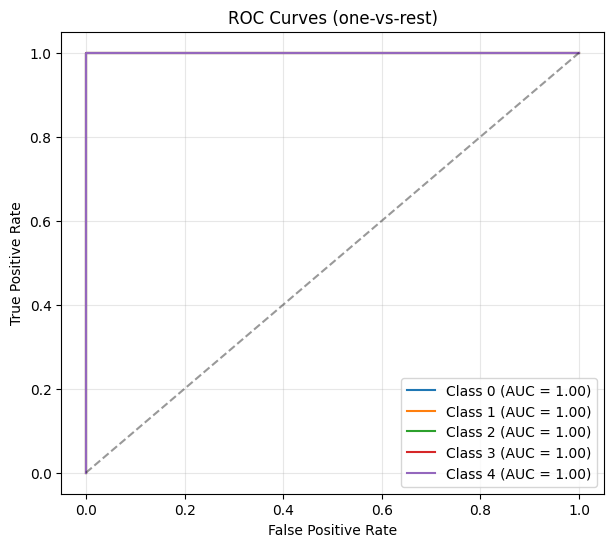

In [15]:
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))
fpr = dict(); tpr = dict(); roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7,6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (one-vs-rest)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


**Decision boundary plot**

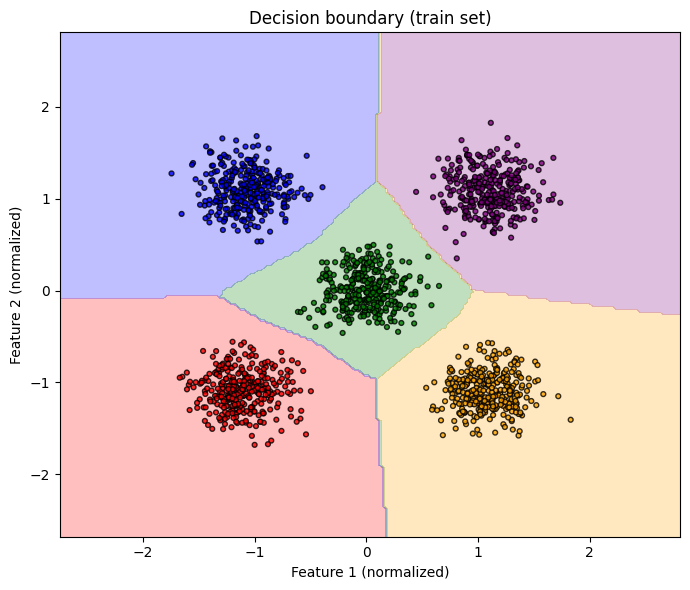

In [17]:
h = 0.03
x_min, x_max = X_train_norm[:,0].min()-1.0, X_train_norm[:,0].max()+1.0
y_min, y_max = X_train_norm[:,1].min()-1.0, X_train_norm[:,1].max()+1.0
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

Z = model.predict_class(grid)
Z = Z.reshape(xx.shape)

cmap = ListedColormap(colors[:num_classes])
plt.figure(figsize=(7,6))
plt.contourf(xx, yy, Z, alpha=0.25, cmap=cmap, levels=np.arange(num_classes+1)-0.5)
plt.scatter(X_train_norm[:,0], X_train_norm[:,1], c=y_train, cmap=cmap, s=12, edgecolor='k', alpha=0.8)
plt.title("Decision boundary (train set)")
plt.xlabel("Feature 1 (normalized)")
plt.ylabel("Feature 2 (normalized)")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.tight_layout()
plt.show()